Notebook d'exploration et validation des données Elasticsearch
Débats de l'Assemblée Nationale - Projet Fenêtre d'Overton


# 📊 Exploration des données Elasticsearch

Ce notebook permet de valider visuellement que vos données sont correctement indexées
dans Elasticsearch et correspondent à vos attentes pour le projet d'analyse du

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from elasticsearch import Elasticsearch
from datetime import datetime
import json
from collections import Counter
from wordcloud import WordCloud

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline


In [3]:
es = Elasticsearch("http://localhost:9200")

# Vérifier la connexion
if es.ping():
    print("✅ Connexion à Elasticsearch réussie")
    
    # Informations sur le cluster
    info = es.info()
    print(f"\n📌 Version Elasticsearch: {info['version']['number']}")
    print(f"📌 Nom du cluster: {info['cluster_name']}")
else:
    print("❌ Impossible de se connecter à Elasticsearch")



✅ Connexion à Elasticsearch réussie

📌 Version Elasticsearch: 8.10.0
📌 Nom du cluster: docker-cluster


2️⃣ Informations sur l'index


In [4]:
index_name = "debats_assemblee_nationale"

# Vérifier si l'index existe
if es.indices.exists(index=index_name):
    print(f"✅ L'index '{index_name}' existe\n")
    
    # Statistiques de l'index
    stats = es.indices.stats(index=index_name)
    count = es.count(index=index_name)
    
    print(f"📊 Statistiques de l'index:")
    print(f"   • Nombre total de documents: {count['count']:,}")
    print(f"   • Taille de l'index: {stats['indices'][index_name]['total']['store']['size_in_bytes'] / (1024*1024):.2f} MB")
    
    # Mapping de l'index
    mapping = es.indices.get_mapping(index=index_name)
    properties = mapping[index_name]['mappings']['properties']
    print(f"   • Nombre de champs: {len(properties)}")
    
else:
    print(f"❌ L'index '{index_name}' n'existe pas")
    print("Exécutez d'abord le script d'extraction pour créer l'index")


✅ L'index 'debats_assemblee_nationale' existe

📊 Statistiques de l'index:
   • Nombre total de documents: 1,457
   • Taille de l'index: 0.63 MB
   • Nombre de champs: 29


3️⃣ Aperçu du mapping (structure des données)


In [5]:
print("🗺️  Structure des données (Mapping):\n")
for field, details in sorted(properties.items()):
    field_type = details.get('type', 'object')
    print(f"   • {field:30s} → {field_type}")


🗺️  Structure des données (Mapping):

   • annee                          → integer
   • date_parution                  → date
   • date_seance                    → date
   • document_id                    → keyword
   • extraction_timestamp           → date
   • folio                          → integer
   • legislature                    → integer
   • mois                           → integer
   • mots_cles_insecurite           → keyword
   • niveau_section                 → integer
   • nombre_suffrages_exprimes      → integer
   • nombre_votants                 → integer
   • numero_premiere_page           → integer
   • orateur_fonction               → keyword
   • orateur_nom                    → text
   • para_id                        → keyword
   • polarite                       → float
   • publication_numero             → integer
   • seance_numero                  → keyword
   • section_id                     → keyword
   • section_titre                  → text
   • sentimen

4️⃣ Échantillon de documents

In [6]:
sample_query = {
    "size": 3,
    "sort": [{"date_seance": {"order": "desc"}}]
}

response = es.search(index=index_name, body=sample_query)

print(f"📄 Échantillon de {len(response['hits']['hits'])} documents:\n")
print("=" * 80)

for i, hit in enumerate(response['hits']['hits'], 1):
    doc = hit['_source']
    print(f"\n🔹 Document {i}:")
    print(f"   Date séance: {doc.get('date_seance', 'N/A')}")
    print(f"   Législature: {doc.get('legislature', 'N/A')}")
    print(f"   Orateur: {doc.get('orateur_nom', 'N/A')}")
    print(f"   Fonction: {doc.get('orateur_fonction', 'N/A')}")
    print(f"   Section: {doc.get('section_titre', 'N/A')[:80]}...")
    print(f"   Texte (extrait): {doc.get('texte', 'N/A')[:150]}...")
    print(f"   Vote présent: {doc.get('vote_present', False)}")
    if doc.get('vote_present'):
        print(f"   Votes pour: {doc.get('votes_pour', 'N/A')}, contre: {doc.get('votes_contre', 'N/A')}")



📄 Échantillon de 3 documents:


🔹 Document 1:
   Date séance: 2022-01-03
   Législature: 15
   Orateur: Mme la présidente.
   Fonction: Président
   Section: Outils de gestion de la crise sanitaire...
   Texte (extrait): Mme la présidente. L’ordre du jour appelle la discussion du projet de loi renforçant les outils de gestion de la crise sanitaire et modifiant le code ...
   Vote présent: False

🔹 Document 2:
   Date séance: 2022-01-03
   Législature: 15
   Orateur: Mme la présidente.
   Fonction: Président
   Section: Outils de gestion de la crise sanitaire...
   Texte (extrait): Mme la présidente. La parole est à M. le ministre des solidarités et de la santé....
   Vote présent: False

🔹 Document 3:
   Date séance: 2022-01-03
   Législature: 15
   Orateur: M. Olivier Véran,
   Fonction: Député
   Section: Outils de gestion de la crise sanitaire...
   Texte (extrait): M. Olivier Véran, ministre des solidarités et de la santé . Depuis plusieurs semaines, nous attendions avec impatience

/tmp/ipykernel_31085/3396805782.py:6: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(index=index_name, body=sample_query)


5️⃣ Conversion en DataFrame pour analyse

In [7]:
def get_all_documents(index_name, batch_size=1000):
    """
    Récupère tous les documents d'un index avec pagination
    """
    documents = []
    
    # Première requête
    response = es.search(
        index=index_name,
        scroll='2m',
        size=batch_size,
        body={"query": {"match_all": {}}}
    )
    
    scroll_id = response['_scroll_id']
    hits = response['hits']['hits']
    documents.extend([hit['_source'] for hit in hits])
    
    print(f"Récupération des documents: {len(documents)}", end="")
    
    # Pagination
    while len(hits) > 0:
        response = es.scroll(scroll_id=scroll_id, scroll='2m')
        scroll_id = response['_scroll_id']
        hits = response['hits']['hits']
        documents.extend([hit['_source'] for hit in hits])
        print(f"...{len(documents)}", end="")
    
    print(f" ✅ Terminé!")
    
    # Nettoyer le scroll
    es.clear_scroll(scroll_id=scroll_id)
    
    return documents

print("📥 Récupération de tous les documents...")
all_docs = get_all_documents(index_name)
df = pd.DataFrame(all_docs)

print(f"\n✅ DataFrame créé avec {len(df):,} lignes et {len(df.columns)} colonnes")

# %% Afficher les premières lignes
print("\n📋 Aperçu du DataFrame:")
df.head()


/tmp/ipykernel_31085/72311461.py:8: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(


📥 Récupération de tous les documents...
Récupération des documents: 1000...1457...1457 ✅ Terminé!

✅ DataFrame créé avec 1,457 lignes et 21 colonnes

📋 Aperçu du DataFrame:


,publication_numero,date_parution,date_seance,annee,mois,session_nom,session_parlementaire,legislature,numero_premiere_page,section_id,...,para_id,orateur_nom,orateur_fonction,texte,extraction_timestamp,vote_present,nombre_votants,nombre_suffrages_exprimes,votes_pour,votes_contre
0,1,2022-01-04,2022-01-03,2022,1,ordinaire,2021-2022,15,1,w1aab2ab1ab1i00079,...,w1aab2ab1ab1i00084,Mme la présidente.,Président,Mme la présidente. L’ordre du jour appelle la ...,2025-10-24T10:09:07.812123,False,NaN,NaN,NaN,NaN
1,1,2022-01-04,2022-01-03,2022,1,ordinaire,2021-2022,15,1,w1aab2ab1ab1i00079,...,w1aab2ab1ab1i00088,Mme la présidente.,Président,Mme la présidente. La parole est à M. le minis...,2025-10-24T10:09:07.812186,False,NaN,NaN,NaN,NaN
2,1,2022-01-04,2022-01-03,2022,1,ordinaire,2021-2022,15,1,w1aab2ab1ab1i00079,...,w1aab2ab1ab1i00089,"M. Olivier Véran,",Député,"M. Olivier Véran, ministre des solidarités et ...",2025-10-24T10:09:07.812276,False,NaN,NaN,NaN,NaN
3,1,2022-01-04,2022-01-03,2022,1,ordinaire,2021-2022,15,1,w1aab2ab1ab1i00079,...,w1aab2ab1ab1i00090,NaN,NaN,Cette période est incontestablement difficile....,2025-10-24T10:09:07.812334,False,NaN,NaN,NaN,NaN
4,1,2022-01-04,2022-01-03,2022,1,ordinaire,2021-2022,15,1,w1aab2ab1ab1i00079,...,w1aab2ab1ab1i00091,NaN,NaN,"Le raz-de-marée est donc là et bien là, et il ...",2025-10-24T10:09:07.812418,False,NaN,NaN,NaN,NaN


In [8]:
ligne1 = df[df['section_id'] == 'w1aab2ab1ab1i01181']

In [14]:
ligne1

,publication_numero,date_parution,date_seance,annee,mois,session_nom,session_parlementaire,legislature,numero_premiere_page,section_id,...,para_id,orateur_nom,orateur_fonction,texte,extraction_timestamp,vote_present,nombre_votants,nombre_suffrages_exprimes,votes_pour,votes_contre
933,1,2022-01-04,2022-01-03,2022,1,ordinaire,2021-2022,15,1,w1aab2ab1ab1i01181,...,w1aab2ab1ab1i01183,Mme la présidente.,Président,"Mme la présidente. Prochaine séance, ce soir, ...",2025-10-24T10:09:07.836769,False,NaN,NaN,NaN,NaN
934,1,2022-01-04,2022-01-03,2022,1,ordinaire,2021-2022,15,1,w1aab2ab1ab1i01181,...,w1aab2ab1ab1i01184,NaN,NaN,Suite de la discussion du projet de loi renfor...,2025-10-24T10:09:07.836777,False,NaN,NaN,NaN,NaN
935,1,2022-01-04,2022-01-03,2022,1,ordinaire,2021-2022,15,1,w1aab2ab1ab1i01181,...,w1aab2ab1ab1i01185,NaN,NaN,La séance est levée.,2025-10-24T10:09:07.836780,False,NaN,NaN,NaN,NaN


In [26]:
response = es.search(
    index=index_name,
    query={"term": {"section_id": "w1aab2ab1ab1i01181"}},
    size=1
)
response

ObjectApiResponse({'took': 6, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 3, 'relation': 'eq'}, 'max_score': 6.032058, 'hits': [{'_index': 'debats_assemblee_nationale', '_id': '-KdDFZoB7e15A1oQrV5W', '_score': 6.032058, '_source': {'publication_numero': 1, 'date_parution': '2022-01-04', 'date_seance': '2022-01-03', 'annee': 2022, 'mois': 1, 'session_nom': 'ordinaire', 'session_parlementaire': '2021-2022', 'legislature': 15, 'numero_premiere_page': 1, 'section_id': 'w1aab2ab1ab1i01181', 'section_titre': 'Ordre du jour de la prochaine séance', 'para_id': 'w1aab2ab1ab1i01183', 'orateur_nom': 'Mme la présidente.', 'orateur_fonction': 'Président', 'texte': 'Mme la présidente. Prochaine séance, ce soir, à vingt et une heures trente\x80:', 'extraction_timestamp': '2025-10-24T10:09:07.836769', 'vote_present': False}}]}})

In [9]:
df_vote = df[df["vote_present"] == True]
df_vote


,publication_numero,date_parution,date_seance,annee,mois,session_nom,session_parlementaire,legislature,numero_premiere_page,section_id,...,para_id,orateur_nom,orateur_fonction,texte,extraction_timestamp,vote_present,nombre_votants,nombre_suffrages_exprimes,votes_pour,votes_contre
932,1,2022-01-04,2022-01-03,2022,1,ordinaire,2021-2022,15,1,w1aab2ab1ab1i00079,...,w1aab2ab1ab1i01180,Mme la présidente.,Président,Mme la présidente. La suite de la discussion e...,2025-10-24T10:09:07.836665,True,243.0,231.0,31.0,200.0


6️⃣ Statistiques descriptives

In [10]:
df.info()

# %% Statistiques par colonne
print("\n📈 Statistiques descriptives:")
print(f"\n{'='*60}")
print(f"Période couverte:")
print(f"   • Première séance: {df['date_seance'].min()}")
print(f"   • Dernière séance: {df['date_seance'].max()}")
print(f"\n{'='*60}")
print(f"Législatures:")
print(df['legislature'].value_counts().sort_index())
print(f"\n{'='*60}")
print(f"Sessions:")
print(df['session_nom'].value_counts())
print(f"\n{'='*60}")
print(f"Fonctions des orateurs:")
print(df['orateur_fonction'].value_counts())
print(f"\n{'='*60}")
print(f"Interventions avec vote:")
print(df['vote_present'].value_counts())
print(f"\n{'='*60}")
print(f"Statistiques sur la longueur des textes:")
df['texte_length'] = df['texte'].str.len()
print(df['texte_length'].describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1457 entries, 0 to 1456
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   publication_numero         1457 non-null   int64  
 1   date_parution              1457 non-null   object 
 2   date_seance                1457 non-null   object 
 3   annee                      1457 non-null   int64  
 4   mois                       1457 non-null   int64  
 5   session_nom                1457 non-null   object 
 6   session_parlementaire      1457 non-null   object 
 7   legislature                1457 non-null   int64  
 8   numero_premiere_page       1457 non-null   int64  
 9   section_id                 1457 non-null   object 
 10  section_titre              1457 non-null   object 
 11  para_id                    1457 non-null   object 
 12  orateur_nom                961 non-null    object 
 13  orateur_fonction           961 non-null    objec

7️⃣ Visualisations


/tmp/ipykernel_31085/2996448431.py:46: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_31085/2996448431.py:46: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_31085/2996448431.py:46: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_31085/2996448431.py:46: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/jules/miniconda3/envs/datadebat/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/jules/miniconda3/envs/datadebat/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io,

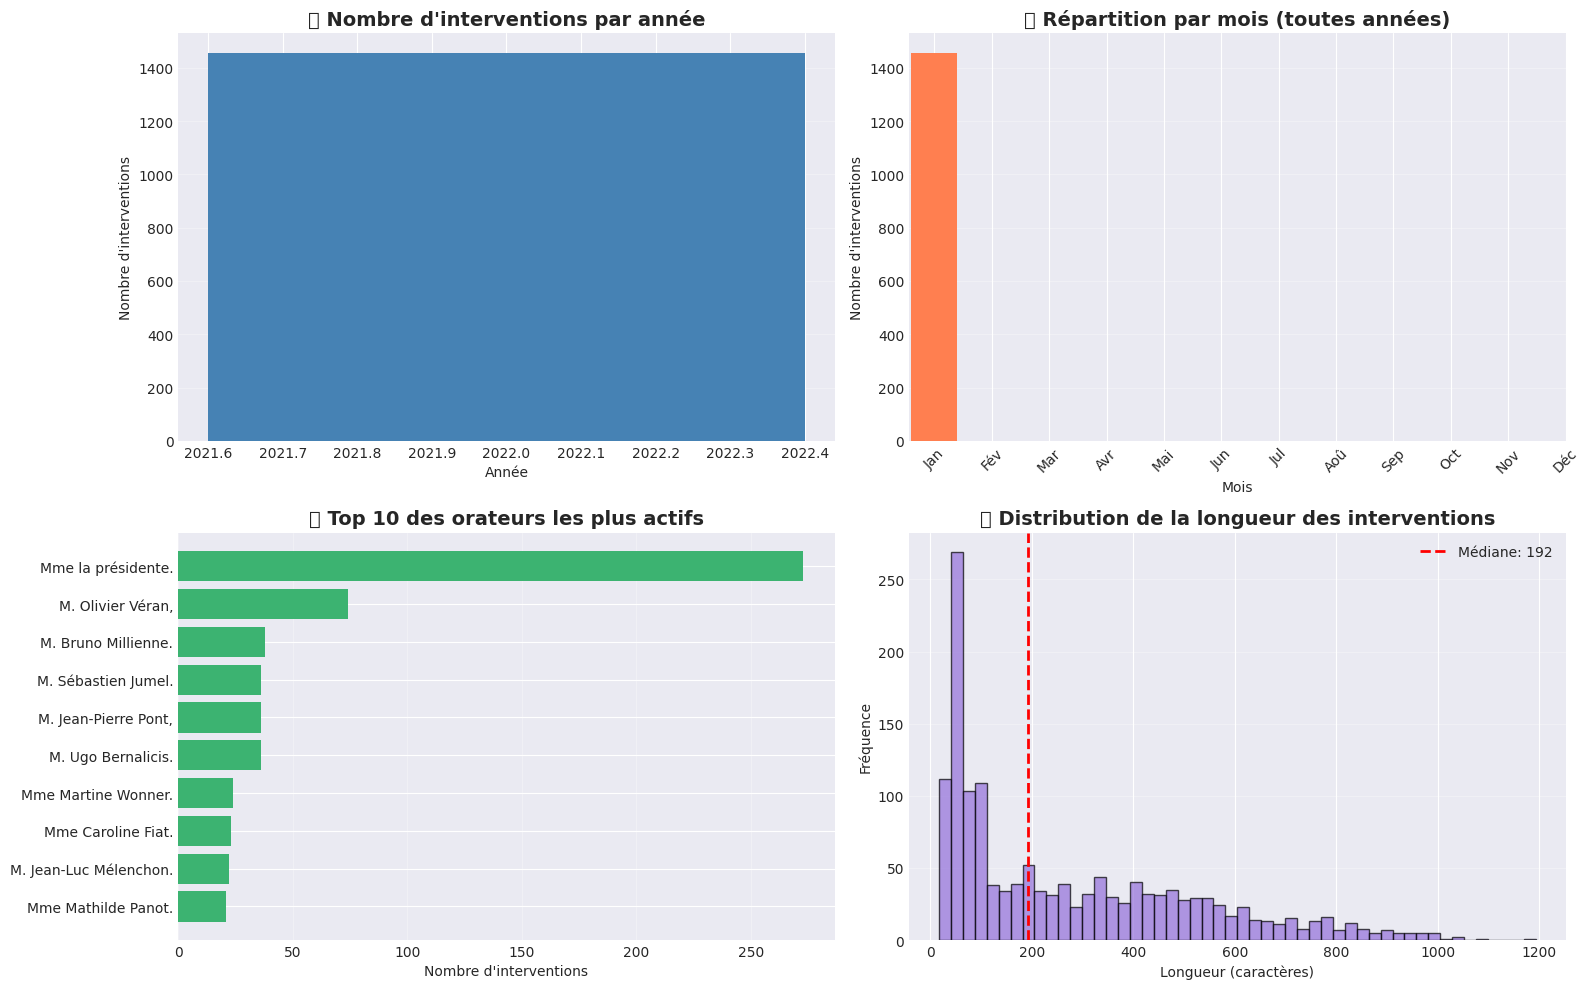

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Convertir les dates
df['date_seance'] = pd.to_datetime(df['date_seance'])
df['annee'] = df['date_seance'].dt.year
df['mois'] = df['date_seance'].dt.month

# 1. Interventions par année
interventions_par_annee = df['annee'].value_counts().sort_index()
axes[0, 0].bar(interventions_par_annee.index, interventions_par_annee.values, color='steelblue')
axes[0, 0].set_title('📅 Nombre d\'interventions par année', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Année')
axes[0, 0].set_ylabel('Nombre d\'interventions')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Interventions par mois (tous confondus)
interventions_par_mois = df['mois'].value_counts().sort_index()
mois_labels = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun', 'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc']
axes[0, 1].bar(interventions_par_mois.index, interventions_par_mois.values, color='coral')
axes[0, 1].set_title('📆 Répartition par mois (toutes années)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Mois')
axes[0, 1].set_ylabel('Nombre d\'interventions')
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].set_xticklabels(mois_labels, rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Top 10 orateurs
top_orateurs = df['orateur_nom'].value_counts().head(10)
axes[1, 0].barh(range(len(top_orateurs)), top_orateurs.values, color='mediumseagreen')
axes[1, 0].set_yticks(range(len(top_orateurs)))
axes[1, 0].set_yticklabels(top_orateurs.index, fontsize=10)
axes[1, 0].set_title('👥 Top 10 des orateurs les plus actifs', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Nombre d\'interventions')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. Distribution de la longueur des textes
axes[1, 1].hist(df['texte_length'], bins=50, color='mediumpurple', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('📏 Distribution de la longueur des interventions', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Longueur (caractères)')
axes[1, 1].set_ylabel('Fréquence')
axes[1, 1].axvline(df['texte_length'].median(), color='red', linestyle='--', linewidth=2, label=f'Médiane: {df["texte_length"].median():.0f}')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


8️⃣ Analyse lexicale préliminaire - Mots les plus fréquents

☁️ Génération du nuage de mots (peut prendre quelques secondes)...


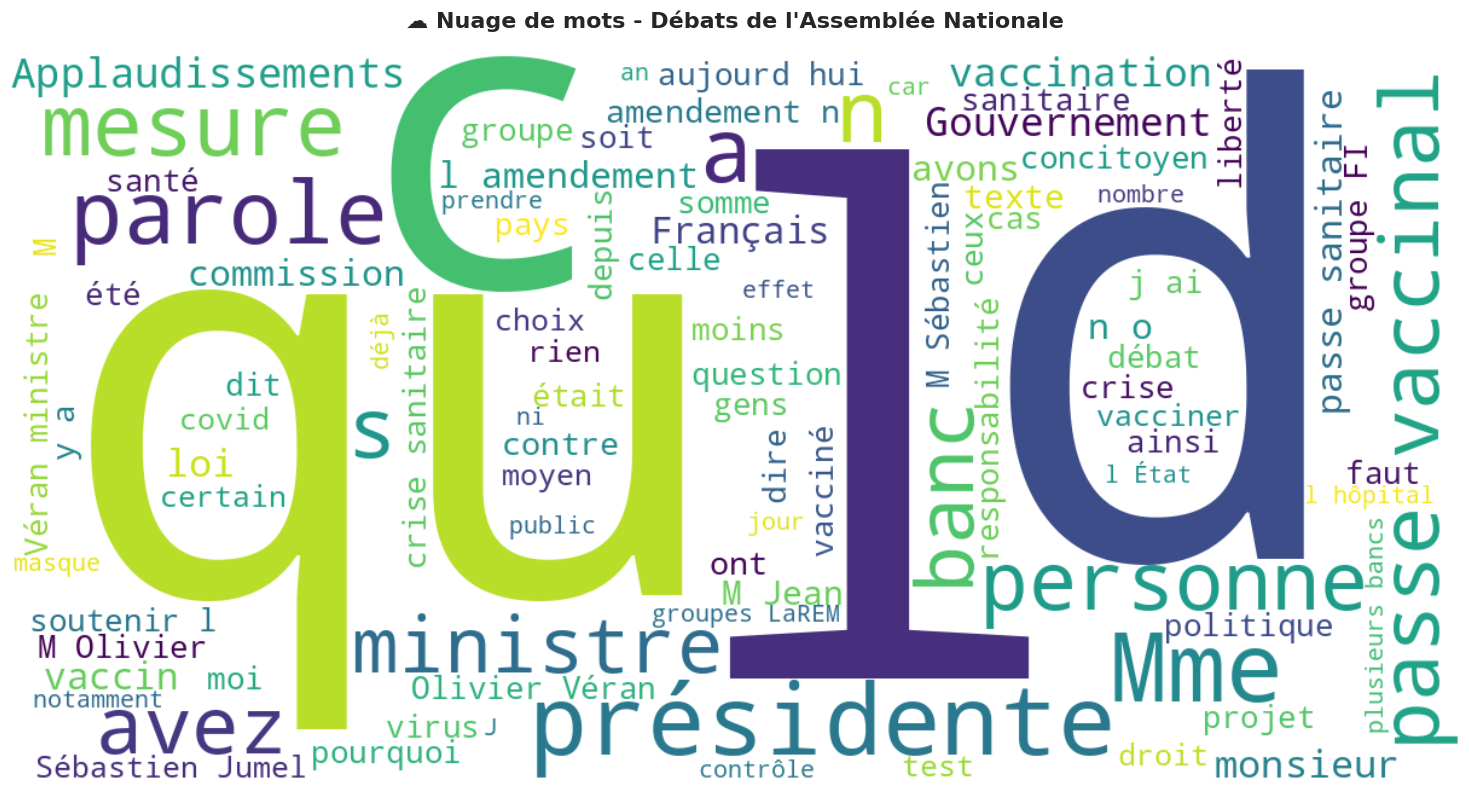

In [12]:
print("☁️ Génération du nuage de mots (peut prendre quelques secondes)...")

# Combiner tous les textes
all_text = ' '.join(df['texte'].dropna().head(1000))  # Limiter à 1000 premiers docs pour la rapidité

# Mots vides français
stopwords_fr = set([
    'le', 'la', 'les', 'un', 'une', 'des', 'de', 'du', 'et', 'en', 'à', 'au', 'aux',
    'pour', 'par', 'sur', 'dans', 'avec', 'sans', 'est', 'sont', 'être', 'avoir',
    'ce', 'cette', 'ces', 'qui', 'que', 'dont', 'où', 'il', 'elle', 'on', 'nous',
    'vous', 'ils', 'elles', 'se', 'sa', 'son', 'ses', 'leur', 'leurs', 'je', 'tu',
    'me', 'te', 'nous', 'vous', 'mon', 'ma', 'mes', 'ton', 'ta', 'tes', 'notre',
    'votre', 'nos', 'vos', 'ne', 'pas', 'plus', 'tout', 'tous', 'toute', 'toutes',
    'peut', 'fait', 'faire', 'très', 'bien', 'donc', 'aussi', 'mais', 'ou', 'si',
    'comme', 'alors', 'ici', 'là', 'encore', 'même', 'autre', 'autres', 'cela', 'ceci'
])

# Créer le nuage de mots
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    stopwords=stopwords_fr,
    colormap='viridis',
    max_words=100
).generate(all_text)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('☁️ Nuage de mots - Débats de l\'Assemblée Nationale', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


9️⃣ Recherche d'exemples sur le thème de l'insécurité

In [13]:
def search_theme(query_text, size=10):
    """
    Recherche des interventions contenant un terme spécifique
    """
    search_body = {
        "query": {
            "match": {
                "texte": {
                    "query": query_text,
                    "operator": "or"
                }
            }
        },
        "size": size,
        "sort": [{"date_seance": {"order": "desc"}}],
        "_source": ["date_seance", "orateur_nom", "section_titre", "texte", "legislature"]
    }
    
    response = es.search(index=index_name, body=search_body)
    return response['hits']['hits']

# %% Recherche sur le thème de l'insécurité
themes_insecurite = ["insécurité", "sécurité", "délinquance", "criminalité", "violence"]

print("🔍 Recherche d'interventions sur le thème de l'insécurité:\n")
print("="*80)

for theme in themes_insecurite:
    results = search_theme(theme, size=3)
    print(f"\n🔎 Mot-clé: '{theme}' → {len(results)} résultats (affichage des 3 premiers)")
    
    for i, hit in enumerate(results, 1):
        doc = hit['_source']
        print(f"\n   [{i}] {doc['date_seance']} - {doc['orateur_nom']}")
        print(f"       Section: {doc.get('section_titre', 'N/A')[:70]}...")
        
        # Extraire un extrait contenant le mot-clé
        texte = doc['texte']
        idx = texte.lower().find(theme.lower())
        if idx != -1:
            start = max(0, idx - 50)
            end = min(len(texte), idx + 100)
            extrait = "..." + texte[start:end] + "..."
            print(f"       Extrait: {extrait}")


🔍 Recherche d'interventions sur le thème de l'insécurité:


🔎 Mot-clé: 'insécurité' → 0 résultats (affichage des 3 premiers)

🔎 Mot-clé: 'sécurité' → 3 résultats (affichage des 3 premiers)


/tmp/ipykernel_31085/3416162117.py:19: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  response = es.search(index=index_name, body=search_body)


KeyError: 'orateur_nom'